In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import networkx as nx
from itertools import combinations
from tqdm import tqdm


In [6]:
path = '/Users/g_private/Library/CloudStorage/OneDrive-Personal/Universität Zürich/FS25/Complex Newtworks Yas/data/co-attention.csv'
df=pd.read_csv(path)
df=df.dropna()
df['countries_mentioned_list']=df['countries_mentioned'].apply(lambda x: x.split(','))
df['affiliations_list']=df['affiliations'].apply(lambda x: x.split(','))
df['Mention_number']=df['countries_mentioned_list'].apply(lambda x: len(x))
df['countries_mentioned_list'] = df['countries_mentioned_list'].apply(
    lambda lst: [c.strip().title()           # remove spaces, standard capitalisation
                 .replace('P.R. China', 'China')
                 .replace('Pr China', 'China')
                 .replace('People’s Republic Of China', 'China')
                 .replace('Cn', 'China')
                 for c in lst]
)
df['affiliations_list'] = df['affiliations_list'].apply(
    lambda lst: [c.strip().title()           # remove spaces, standard capitalisation
                 .replace('P.R. China', 'China')
                 .replace('Pr China', 'China')
                 .replace('People’s Republic Of China', 'China')
                 .replace('Cn', 'China')
                 for c in lst])
# flatten with respect to to the aggregated_value column
df = df.loc[df.index.repeat(df['aggregated_value'])].reset_index(drop= True)

df['affiliations_list'] = df['affiliations_list'] \
    .apply(lambda codes: [c.upper() for c in codes])


# List of columns to remove
cols_to_drop = [
    'countries_mentioned',
    'affiliations',
    'aggregated_value',
    #'affiliations_list',
    'Mention_number'
]

# Option 1: create a new DataFrame without those columns
df= df.drop(columns=cols_to_drop)

df['countries_mentioned_list'] = df['countries_mentioned_list'] \
    .apply(lambda codes: [c.upper() for c in codes])
# remove entries with only 1 country mentioned
df = df[df['countries_mentioned_list'].apply(len) > 1]

df['countries_mentioned_list'] = df['countries_mentioned_list'].apply(lambda lst:[c for c in lst if len(c) < 4]) 

df = df[df['countries_mentioned_list'].apply(len) > 1]


Graph: 247 nodes, 17554 edges


  0%|          | 0/50 [00:00<?, ?it/s]/Users/g_private/anaconda3/envs/complex_networks/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:49: UserWarning:

The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.

/Users/g_private/anaconda3/envs/complex_networks/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:50: UserWarning:

The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.

/Users/g_private/anaconda3/envs/complex_networks/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:49: UserWarning:

The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.

/Users/g_private/anaconda3/envs/complex_networks/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised

[<Axes: xlabel='$log_{10}(t)$', ylabel='$log_{10}(t^\\prime)$'>,
 <Axes: xlabel='$log_{10}(t)$', ylabel='NVI'>,
 <Axes: ylabel='Stability'>,
 <Axes: ylabel='# clusters'>,
 <Axes: xlabel='$log_{10}(t)$', ylabel='Block NVI'>]

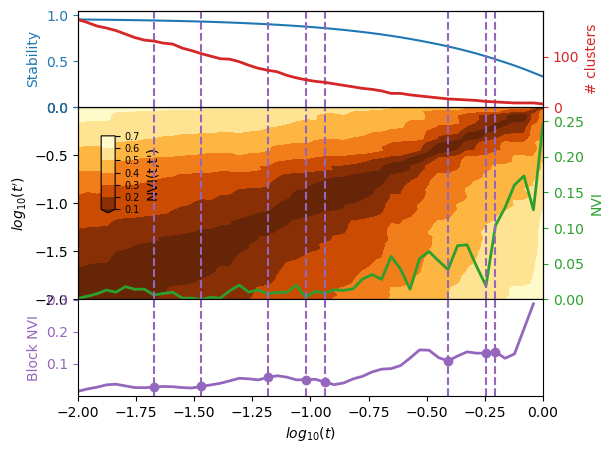

In [7]:
import itertools
from collections import Counter
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse as sp
import pygenstability as pgs
from pygenstability import plotting

# ──────────────────────────────────────────────
# 1) Build co-mention network from your df
# ──────────────────────────────────────────────
def build_comention_graph(df, list_col='countries_mentioned_list', min_weight=0.01, fractional=True):
    edge_counts = Counter()
    for countries in df[list_col]:
        uniq = sorted(set(countries))  # remove duplicates
        k = len(uniq)
        if k < 2:
            continue
        weight_per_edge = 1 / (k * (k - 1) / 2) if fractional else 1
        for u, v in itertools.combinations(uniq, 2):
            edge_counts[(u, v)] += weight_per_edge
    
    G = nx.Graph()
    for (u, v), w in edge_counts.items():
        if w >= min_weight:
            G.add_edge(u, v, weight=w)
    return G

G = build_comention_graph(df, min_weight=0)  # adjust min_weight if needed
print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# ──────────────────────────────────────────────
# 2) Convert to adjacency for PyGenStability
# ──────────────────────────────────────────────
node_order = list(G.nodes())
A = nx.to_numpy_array(G, nodelist=node_order, weight='weight')

# ──────────────────────────────────────────────
# 3) Run multiscale community detection
# ──────────────────────────────────────────────
results = pgs.run(
    sp.csr_matrix(A),
    method="leiden",
    n_scale=50,
    n_tries=100,
    min_scale=-2,        # adjust if you want fewer/more communities
    max_scale=0,
    constructor="linearized",
    n_workers=16
)

# Identify robust scales
results = pgs.identify_optimal_scales(results, kernel_size=4, window_size=2)
plotting.plot_scan(results)


/var/folders/fp/k9ggh24n5jv5pqnjc2558lf80000gn/T/ipykernel_83125/1612319860.py:12: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.




=== Communities at scale 1 ===
Community 0: color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), members=['AUS']
Community 1: color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), members=['USA']
Community 2: color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), members=['DEU']
Community 3: color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), members=['IRL']
Community 4: color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), members=['POL']
Community 5: color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), members=['SWE']
Community 6: color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), members=['CAN']
Community 7: color=(0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0), members=['CHL']
Community 8: color=(0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0), members=['BLR']
Community 9: color=(0.6823529411764706, 0.7

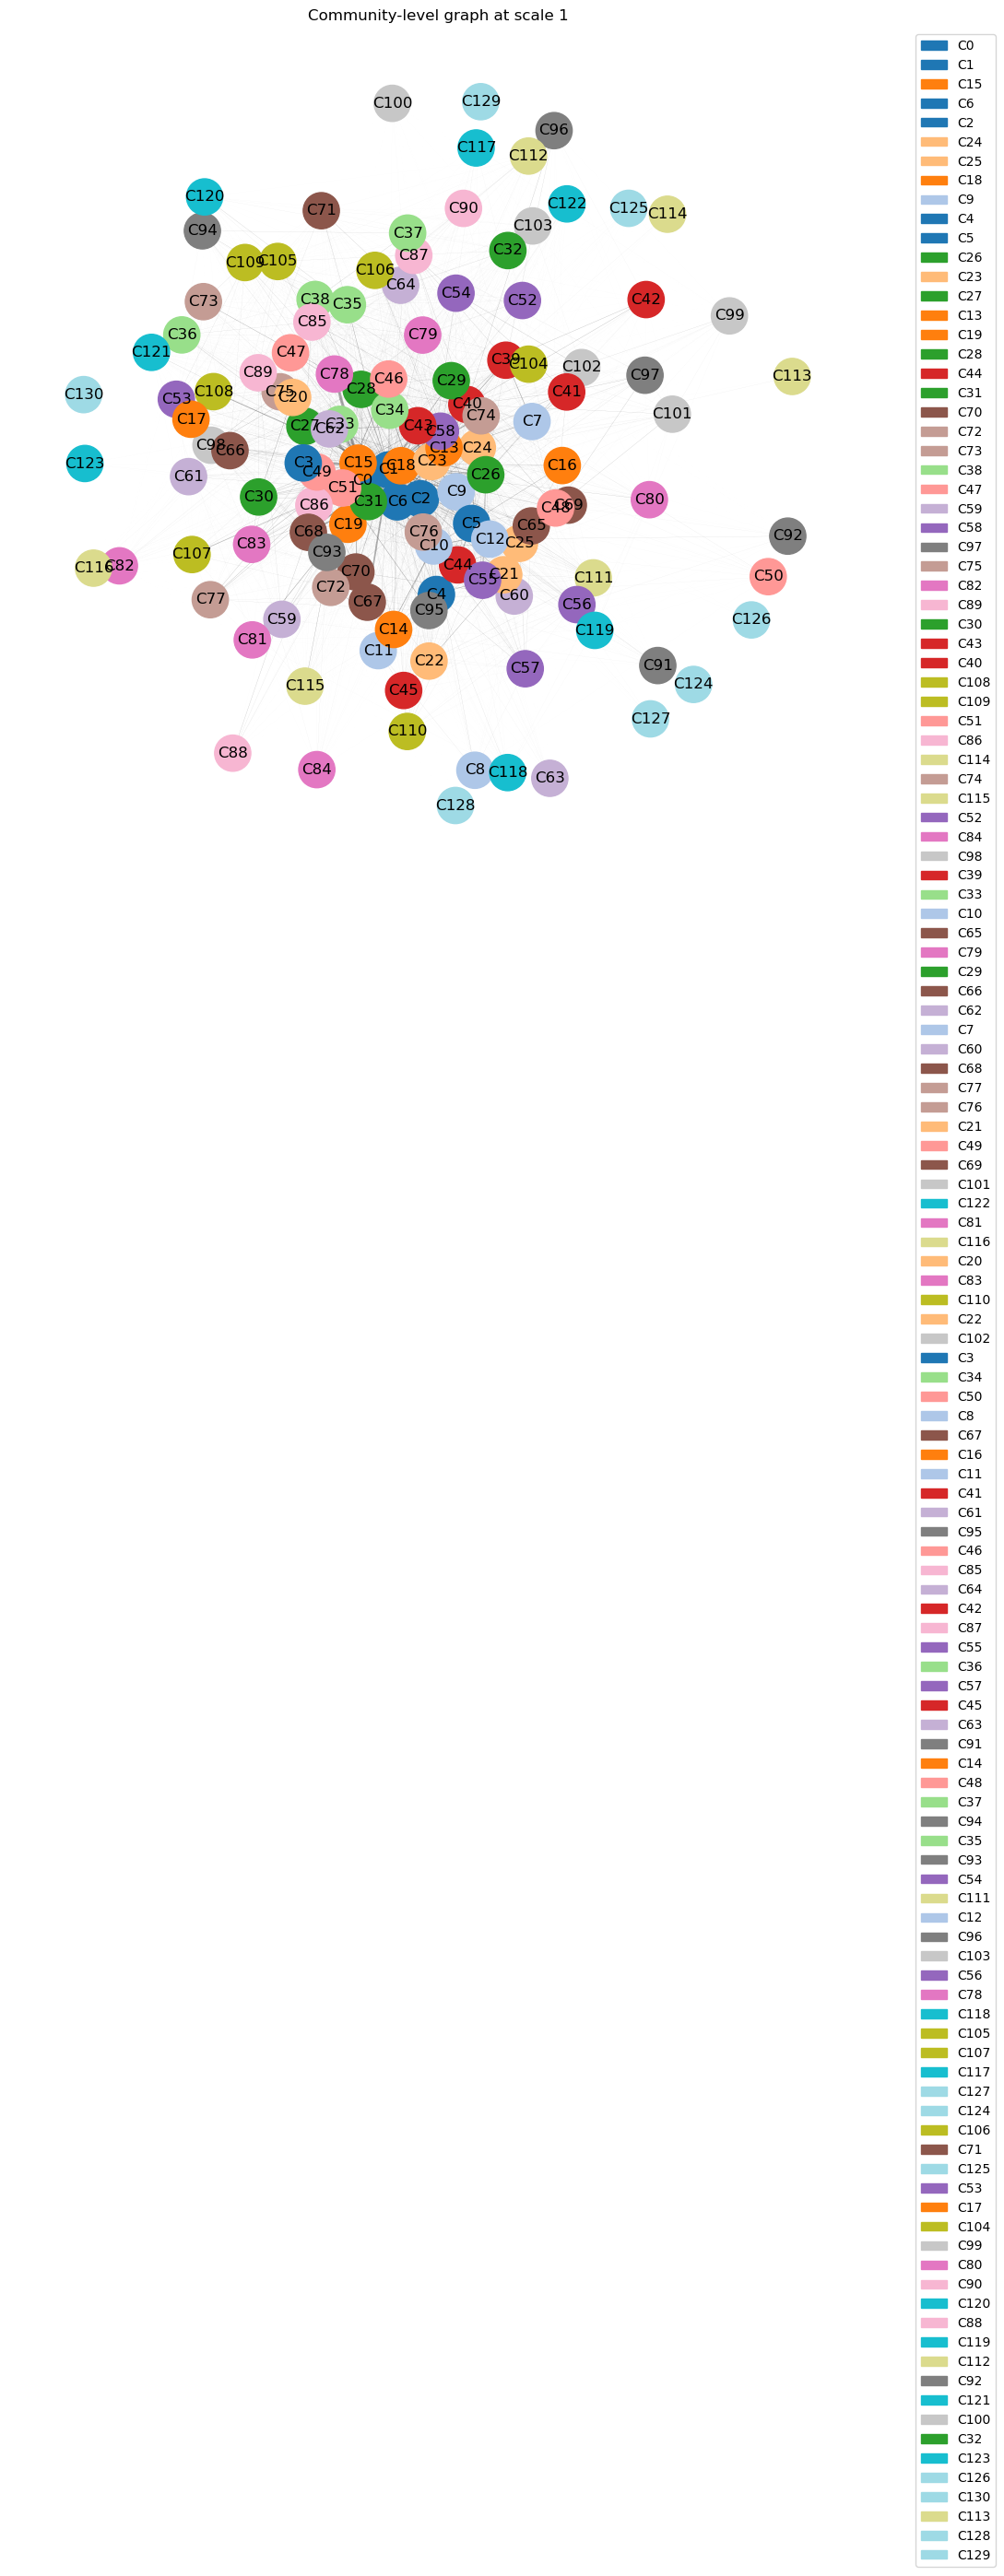


=== Communities at scale 2 ===
Community 0: color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), members=['AUS']
Community 1: color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), members=['USA']
Community 2: color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), members=['DEU']
Community 3: color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), members=['IRL']
Community 4: color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), members=['POL']
Community 5: color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), members=['SWE']
Community 6: color=(0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0), members=['CAN', 'SPM']
Community 7: color=(0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0), members=['CHL']
Community 8: color=(0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0), members=['BLR', 'UKR']
Community 9: color=(0.68235294

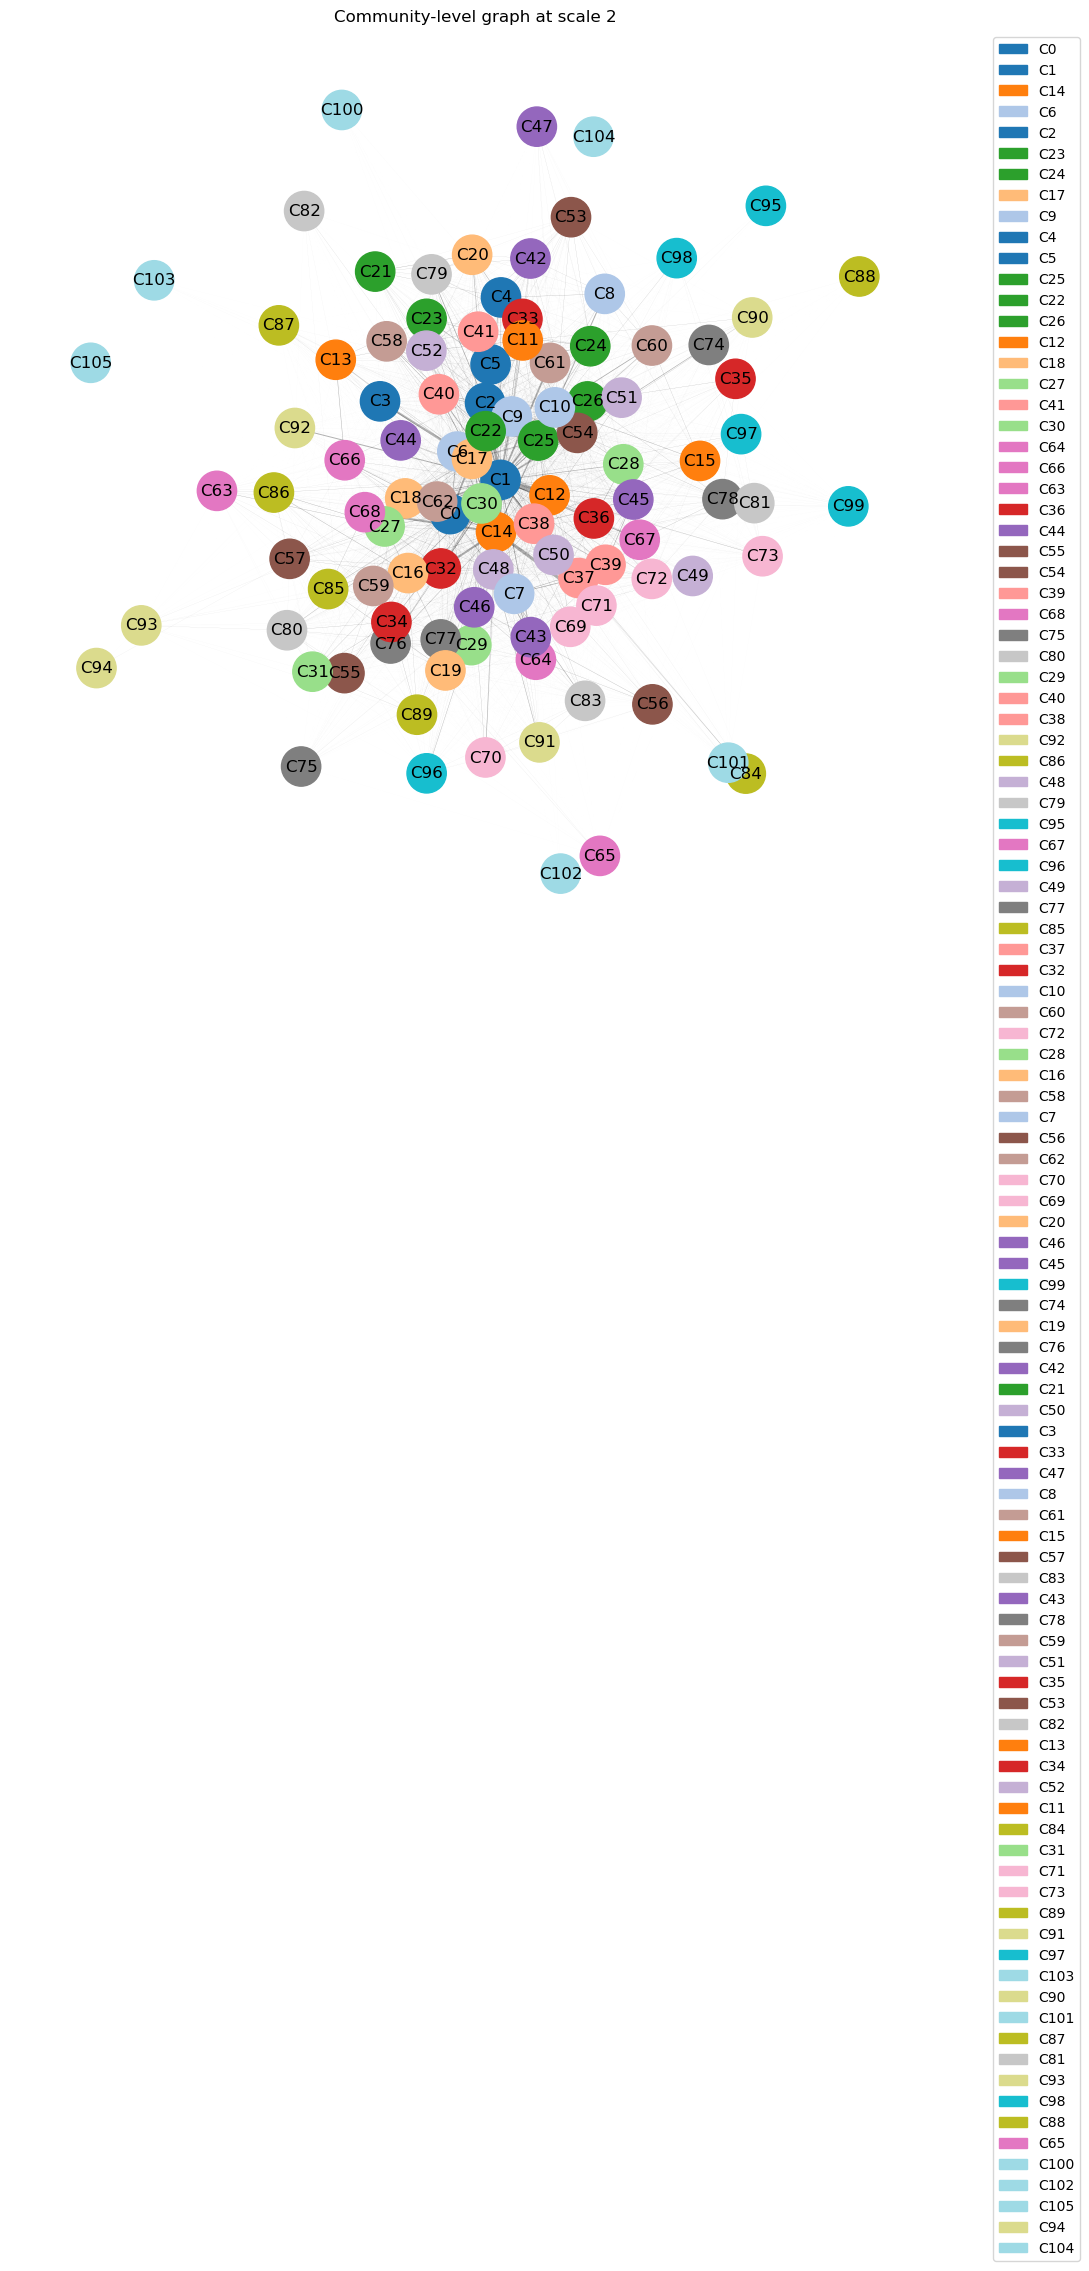


=== Communities at scale 3 ===
Community 0: color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), members=['AUS', 'NZL']
Community 1: color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), members=['USA']
Community 2: color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), members=['DEU']
Community 3: color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), members=['IRL']
Community 4: color=(0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0), members=['POL']
Community 5: color=(0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0), members=['SWE', 'NOR']
Community 6: color=(0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0), members=['CAN', 'SPM']
Community 7: color=(0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0), members=['CHL', 'ARG', 'URY']
Community 8: color=(1.0, 0.4980392156862745, 0.054901960784313725, 1.0), members=['BLR', 'RUS', 'UKR']
Community 

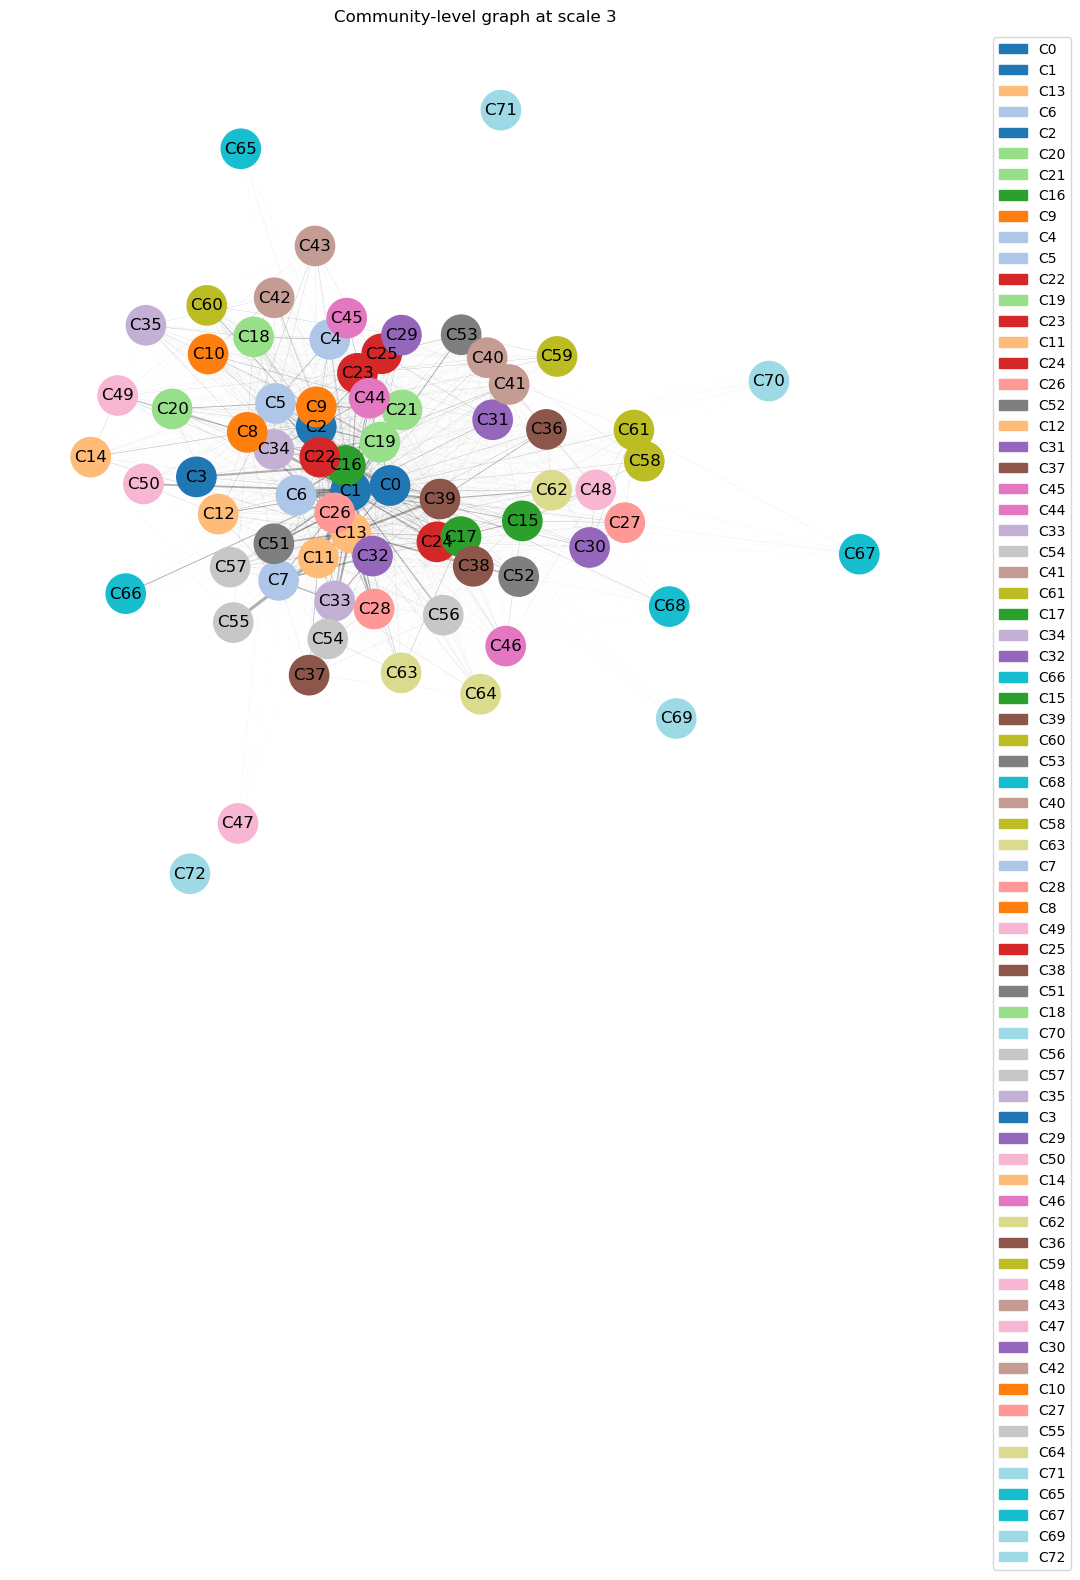


=== Communities at scale 4 ===
Community 0: color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), members=['AUS', 'NZL', 'CXR', 'NFK', 'CCK']
Community 1: color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), members=['USA']
Community 2: color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), members=['DEU']
Community 3: color=(0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0), members=['IRL', 'GBR', 'IMN', 'SJM']
Community 4: color=(0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0), members=['POL', 'CZE', 'HUN', 'SVK', 'CSK']
Community 5: color=(0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0), members=['SWE', 'FIN', 'NOR', 'ALA']
Community 6: color=(1.0, 0.4980392156862745, 0.054901960784313725, 1.0), members=['CAN', 'SPM']
Community 7: color=(1.0, 0.4980392156862745, 0.054901960784313725, 1.0), members=['CHL', 'ARG', 'URY']
Community 8: color=(1.0, 0.7333333333333333, 0.470588235

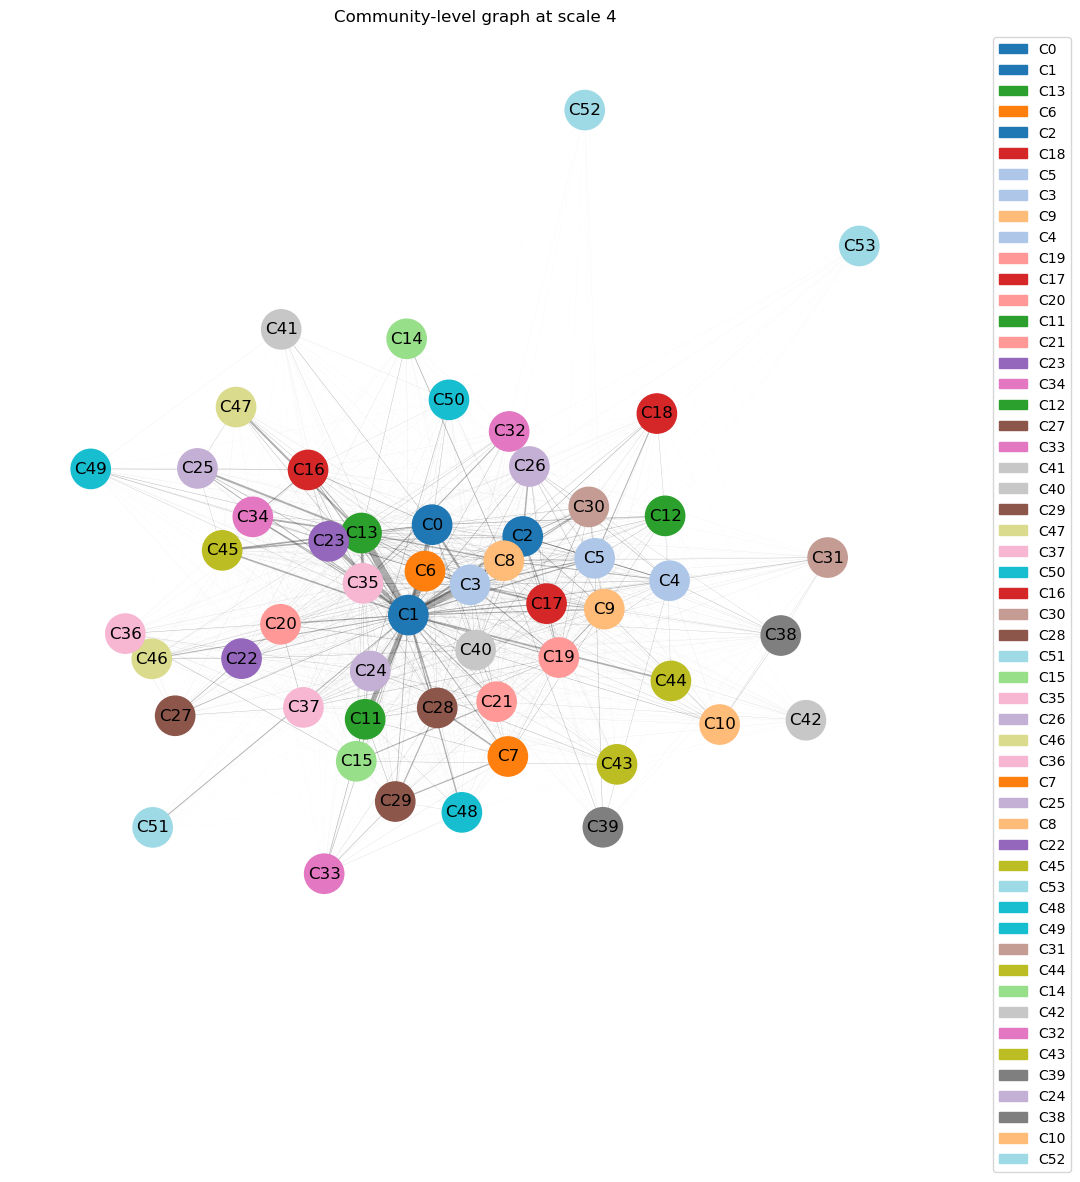


=== Communities at scale 5 ===
Community 0: color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), members=['AUS', 'NZL', 'CXR', 'NFK', 'CCK']
Community 1: color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), members=['USA']
Community 2: color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), members=['DEU']
Community 3: color=(0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0), members=['IRL', 'GBR', 'IMN', 'SJM']
Community 4: color=(0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0), members=['POL', 'CZE', 'HUN', 'SVK', 'CSK']
Community 5: color=(1.0, 0.4980392156862745, 0.054901960784313725, 1.0), members=['SWE', 'DNK', 'FIN', 'NOR', 'ALA']
Community 6: color=(1.0, 0.4980392156862745, 0.054901960784313725, 1.0), members=['CAN', 'SPM']
Community 7: color=(1.0, 0.4980392156862745, 0.054901960784313725, 1.0), members=['CHL', 'PER', 'COL', 'BOL', 'ECU', 'VEN']
Community 8: color=(1.0, 0.73333333333333

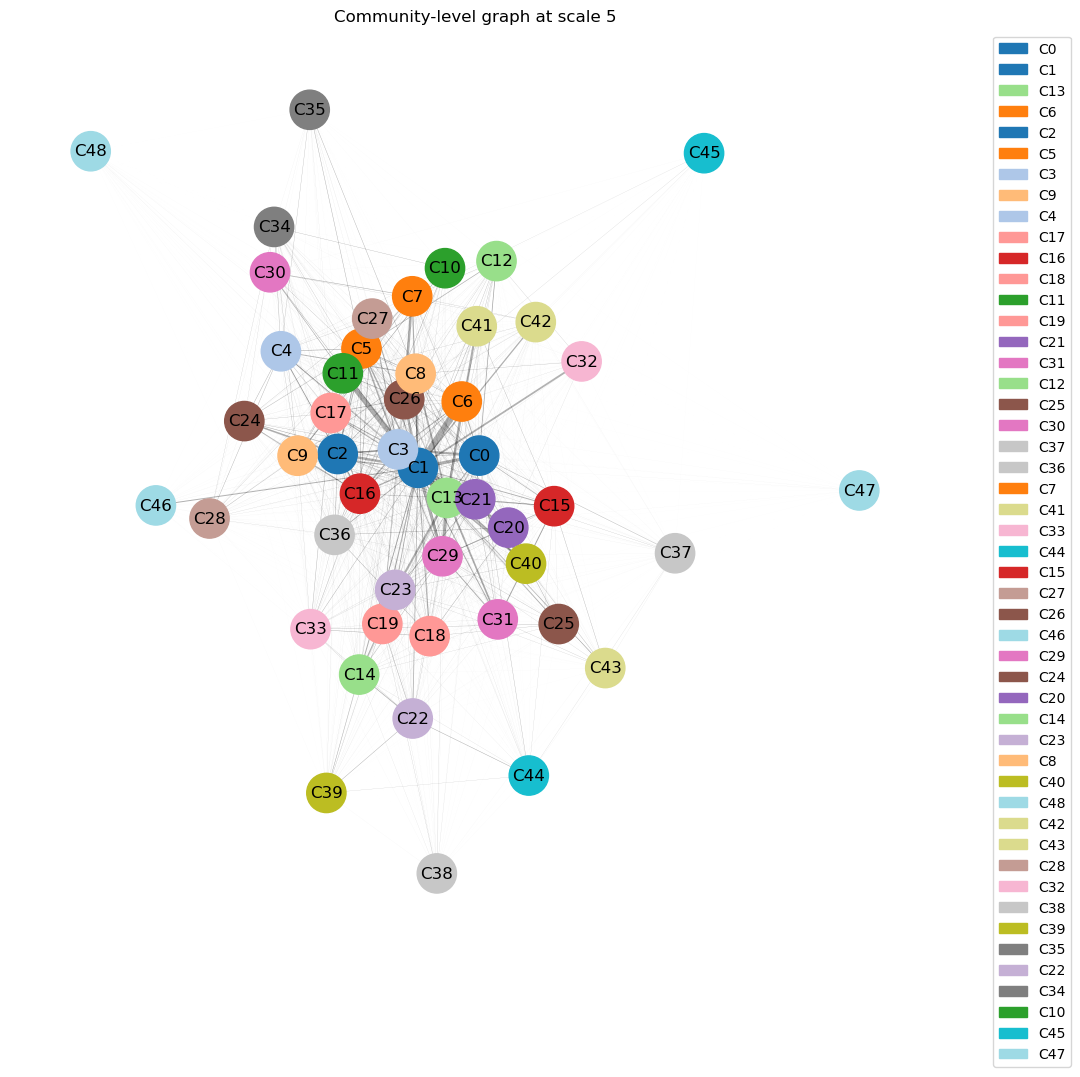


=== Communities at scale 6 ===
Community 0: color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), members=['AUS', 'NZL', 'KIR', 'ATA', 'NCL', 'MNP', 'FJI', 'PYF', 'TON', 'PLW', 'VUT', 'CXR', 'NFK', 'SLB', 'TUV', 'AIA', 'ASM', 'MHL', 'COK', 'WSM', 'GUM', 'NIU', 'TKL', 'PCN', 'BVT', 'NRU', 'ATF', 'WLF', 'CCK', 'SGS', 'HMD']
Community 1: color=(0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0), members=['USA', 'CAN', 'MEX', 'GEO', 'PRI', 'JEY', 'SPM']
Community 2: color=(1.0, 0.4980392156862745, 0.054901960784313725, 1.0), members=['DEU', 'CHE', 'NLD', 'BEL', 'LUX', 'AUT', 'LIE']
Community 3: color=(0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0), members=['IRL', 'GBR', 'IMN', 'GGY', 'IOT', 'SJM']
Community 4: color=(0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0), members=['POL', 'GRC', 'CZE', 'HUN', 'ROU', 'SRB', 'MDA', 'SVK', 'ALB', 'BGR', 'SVN', 'HRV', 'YUG', 'MKD', 'BIH', 'MNE', 'CSK', 'SCG', 'XKS']
Community 5: c

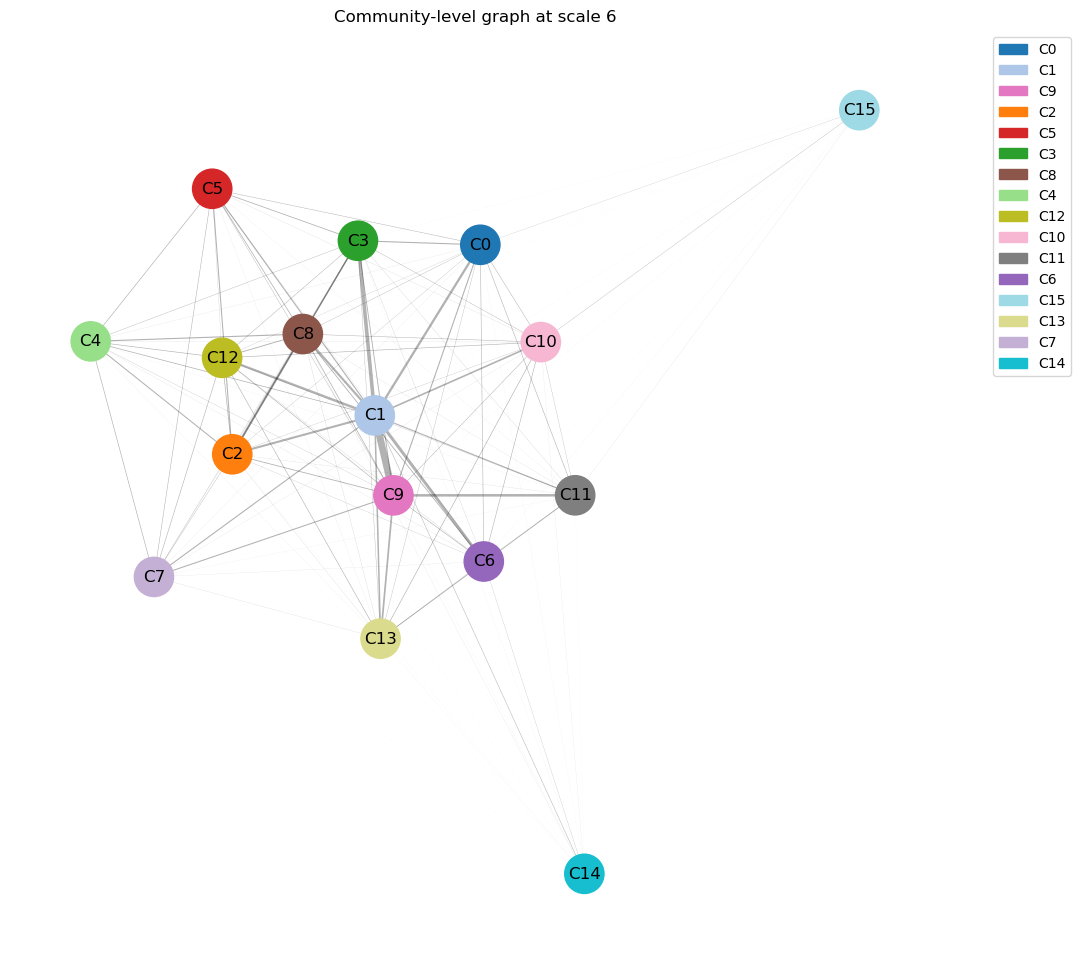


=== Communities at scale 7 ===
Community 0: color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), members=['AUS', 'NZL', 'KIR', 'ATA', 'NCL', 'FJI', 'PYF', 'TON', 'PLW', 'VUT', 'CXR', 'NFK', 'SLB', 'TUV', 'AIA', 'ASM', 'MHL', 'COK', 'WSM', 'NIU', 'TKL', 'PCN', 'BVT', 'NRU', 'ATF', 'WLF', 'CCK', 'SGS', 'HMD']
Community 1: color=(1.0, 0.4980392156862745, 0.054901960784313725, 1.0), members=['USA', 'CAN', 'MEX', 'GEO', 'PRI', 'MNP', 'JEY', 'GUM', 'BMU', 'SPM']
Community 2: color=(0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0), members=['DEU', 'ITA', 'FRA', 'ESP', 'CHE', 'NLD', 'PRT', 'BEL', 'LUX', 'AUT', 'GIB', 'LIE', 'VAT', 'AND', 'SMR', 'MCO']
Community 3: color=(0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0), members=['IRL', 'GBR', 'IMN', 'GGY', 'IOT', 'SJM']
Community 4: color=(0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0), members=['POL', 'BLR', 'RUS', 'UKR', 'KAZ', 'UZB', 'CZE', 'HUN', 'ROU', 'SRB', 'EST',

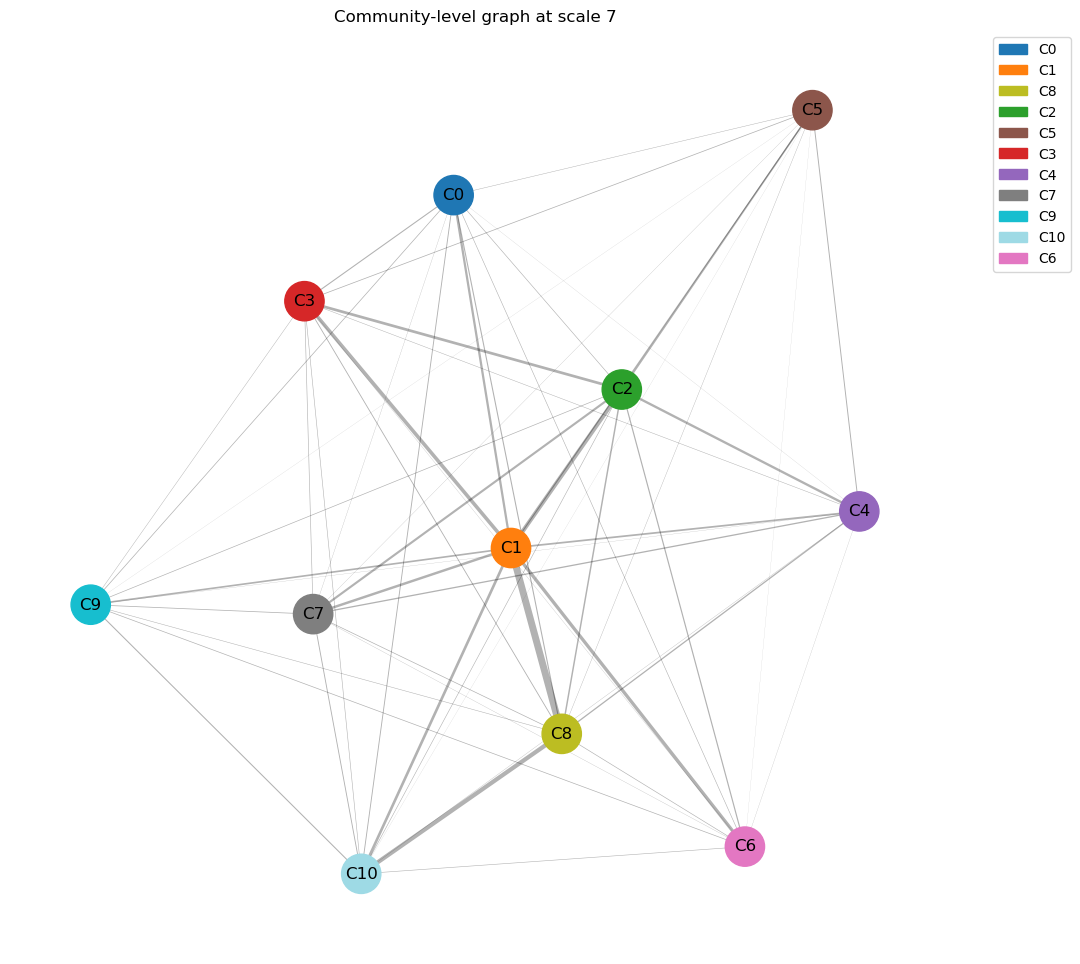


=== Communities at scale 8 ===
Community 0: color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), members=['AUS', 'NZL', 'KIR', 'ATA', 'NCL', 'FJI', 'PYF', 'TON', 'PLW', 'VUT', 'CXR', 'NFK', 'SLB', 'TUV', 'AIA', 'ASM', 'TLS', 'MHL', 'COK', 'WSM', 'NIU', 'TKL', 'PCN', 'BVT', 'NRU', 'ATF', 'WLF', 'CCK', 'SGS', 'HMD']
Community 1: color=(1.0, 0.4980392156862745, 0.054901960784313725, 1.0), members=['USA', 'CAN', 'MEX', 'GEO', 'PRI', 'MNP', 'JEY', 'GUM', 'BMU', 'GGY', 'SPM']
Community 2: color=(0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0), members=['DEU', 'IRL', 'ITA', 'GBR', 'FRA', 'ESP', 'CHE', 'NLD', 'PRT', 'BEL', 'LUX', 'AUT', 'GIB', 'IMN', 'MLT', 'LIE', 'VAT', 'AND', 'SMR', 'MCO', 'SJM']
Community 3: color=(0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0), members=['POL', 'BLR', 'RUS', 'UKR', 'KAZ', 'UZB', 'CZE', 'HUN', 'ROU', 'SRB', 'EST', 'SUN', 'MDA', 'SVK', 'LTU', 'TJK', 'BGR', 'SVN', 'LVA', 'HRV', 'KGZ', 'YUG', 'BIH', 'T

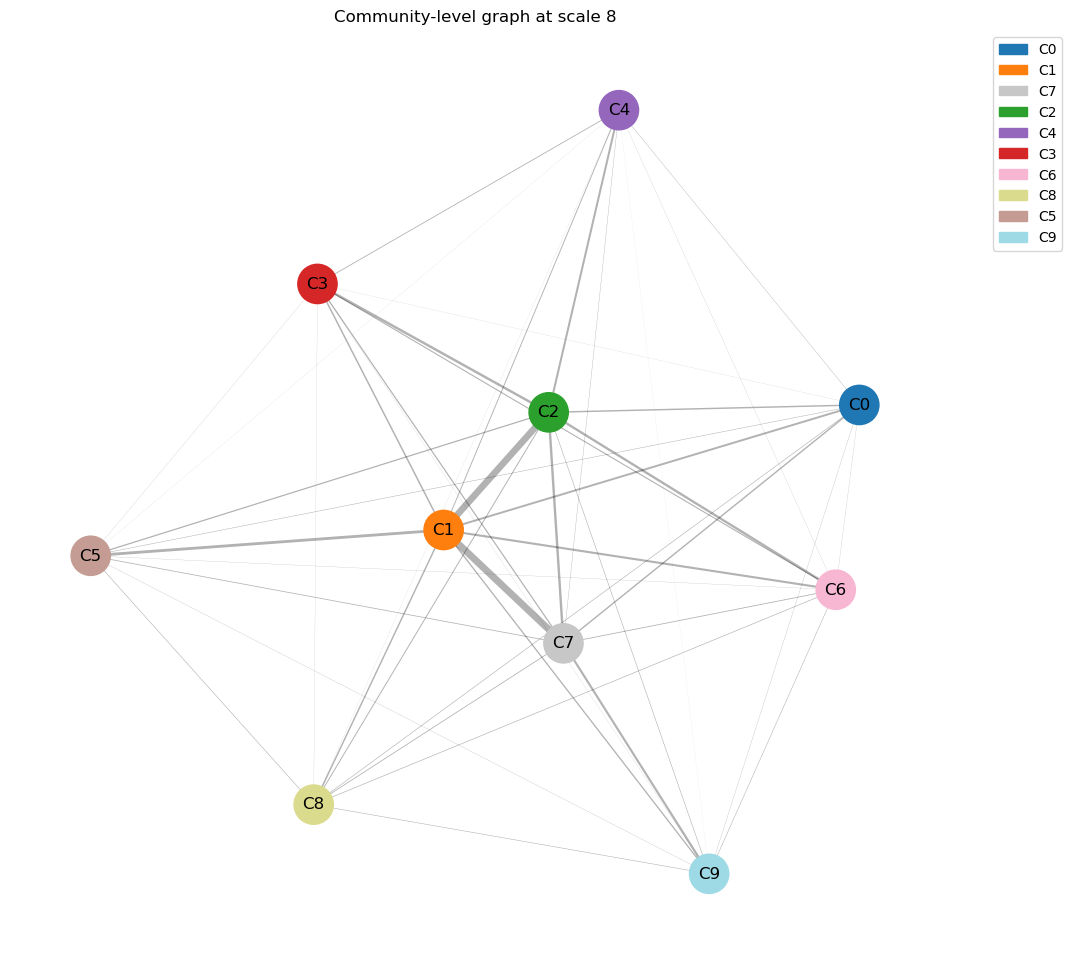

In [8]:
from matplotlib import cm
import matplotlib.patches as mpatches
import networkx as nx

# The detected "best" scales
selected_scales = results["selected_partitions"]

for idx, part_idx in enumerate(selected_scales):
    labels = results["community_id"][part_idx]
    comms = dict(zip(node_order, labels))
    n_comms = len(set(labels))
    palette = cm.get_cmap("tab20", n_comms)
    
    # Print communities and colors
    print(f"\n=== Communities at scale {idx+1} ===")
    community_map = {}
    for node, cid in comms.items():
        community_map.setdefault(cid, []).append(node)
    
    color_map = {}
    for cid, nodes in community_map.items():
        color = palette(cid)
        color_map[cid] = color
        print(f"Community {cid}: color={color}, members={nodes}")

    # Collapse to community graph
    G_comm = nx.Graph()
    for (u, v, d) in G.edges(data=True):
        cu, cv = comms[u], comms[v]
        if cu != cv:
            if G_comm.has_edge(cu, cv):
                G_comm[cu][cv]['weight'] += d['weight']
            else:
                G_comm.add_edge(cu, cv, weight=d['weight'])
    
    # Plot community graph
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G_comm, seed=42, k=5)
    nx.draw_networkx_edges(G_comm, pos, alpha=0.3, width=[G_comm[u][v]['weight']/max(nx.get_edge_attributes(G_comm, 'weight').values())*5 for u, v in G_comm.edges()])
    nx.draw_networkx_nodes(
        G_comm, pos,
        node_color=[color_map[c] for c in G_comm.nodes()],
        node_size=800
    )
    nx.draw_networkx_labels(
        G_comm, pos,
        labels={c: f"C{c}" for c in G_comm.nodes()},
        font_size=12
    )
    
    # Legend
    patches = [mpatches.Patch(color=color_map[cid], label=f"C{cid}") for cid in G_comm.nodes()]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.axis("off")
    plt.title(f"Community-level graph at scale {idx+1}")
    plt.show()



=== Communities at scale 1 ===
Community 0: members=['AUS']
Community 1: members=['USA']
Community 2: members=['DEU']
Community 3: members=['IRL']
Community 4: members=['POL']
Community 5: members=['SWE']
Community 6: members=['CAN']
Community 7: members=['CHL']
Community 8: members=['BLR']
Community 9: members=['ITA']
Community 10: members=['RUS']
Community 11: members=['UKR']
Community 12: members=['GRC', 'MKD']
Community 13: members=['MEX']
Community 14: members=['ISL', 'GRL', 'FRO']
Community 15: members=['CHN']
Community 16: members=['KAZ', 'UZB', 'TJK', 'KGZ', 'TKM']
Community 17: members=['UGA']
Community 18: members=['GBR']
Community 19: members=['NZL']
Community 20: members=['MYS']
Community 21: members=['CZE', 'SVK', 'CSK']
Community 22: members=['HUN']
Community 23: members=['FRA']
Community 24: members=['DNK']
Community 25: members=['FIN', 'ALA']
Community 26: members=['ESP']
Community 27: members=['ISR', 'PSE']
Community 28: members=['ZAF', 'LSO']
Community 29: members=['

/var/folders/fp/k9ggh24n5jv5pqnjc2558lf80000gn/T/ipykernel_83125/4196389305.py:49: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



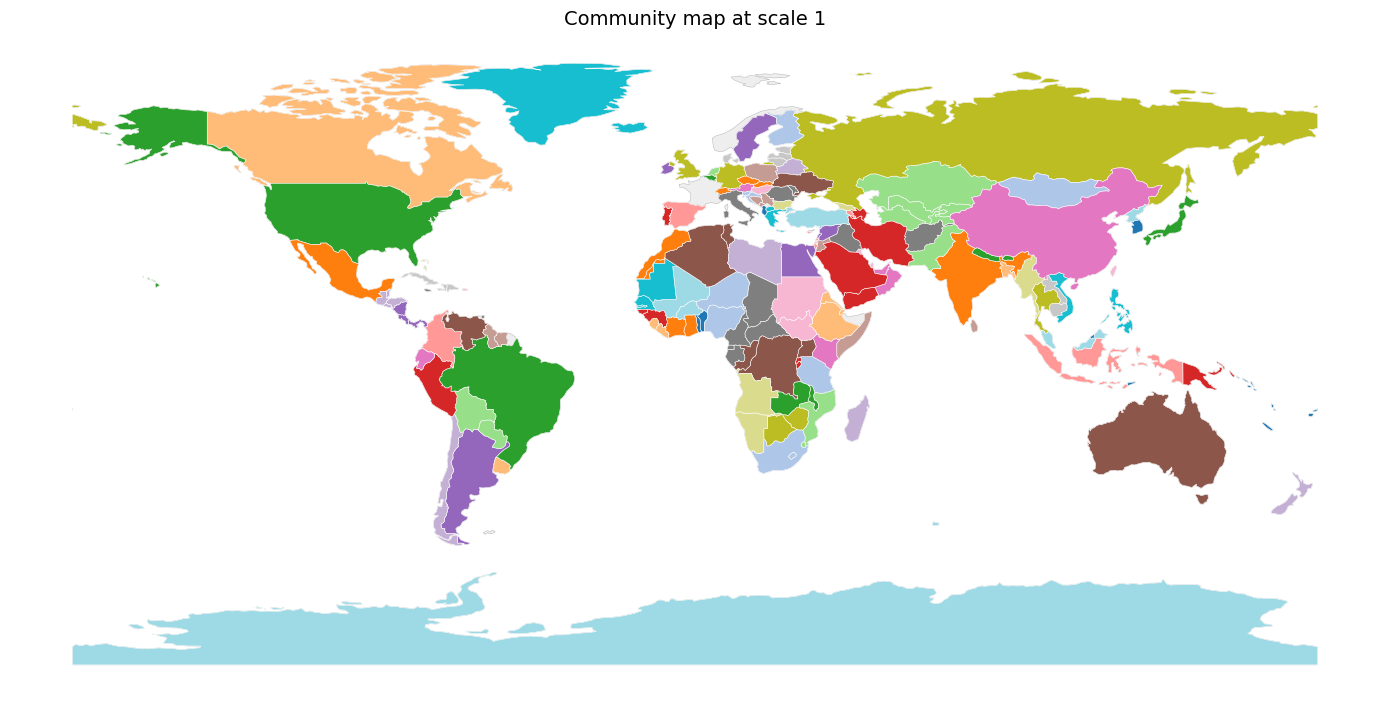


=== Communities at scale 2 ===
Community 0: members=['AUS']
Community 1: members=['USA']
Community 2: members=['DEU']
Community 3: members=['IRL']
Community 4: members=['POL']
Community 5: members=['SWE']
Community 6: members=['CAN', 'SPM']
Community 7: members=['CHL']
Community 8: members=['BLR', 'UKR']
Community 9: members=['ITA']
Community 10: members=['RUS']
Community 11: members=['GRC', 'ALB', 'MKD', 'XKS']
Community 12: members=['MEX']
Community 13: members=['ISL', 'GRL', 'FRO']
Community 14: members=['CHN']
Community 15: members=['KAZ', 'UZB', 'TJK', 'KGZ', 'TKM']
Community 16: members=['UGA', 'TZA', 'KEN']
Community 17: members=['GBR']
Community 18: members=['NZL']
Community 19: members=['MYS', 'BRN']
Community 20: members=['CZE', 'SVK', 'CSK']
Community 21: members=['HUN']
Community 22: members=['FRA']
Community 23: members=['DNK']
Community 24: members=['FIN', 'ALA']
Community 25: members=['ESP']
Community 26: members=['ISR', 'PSE']
Community 27: members=['ZAF', 'LSO']
Commu

/var/folders/fp/k9ggh24n5jv5pqnjc2558lf80000gn/T/ipykernel_83125/4196389305.py:49: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



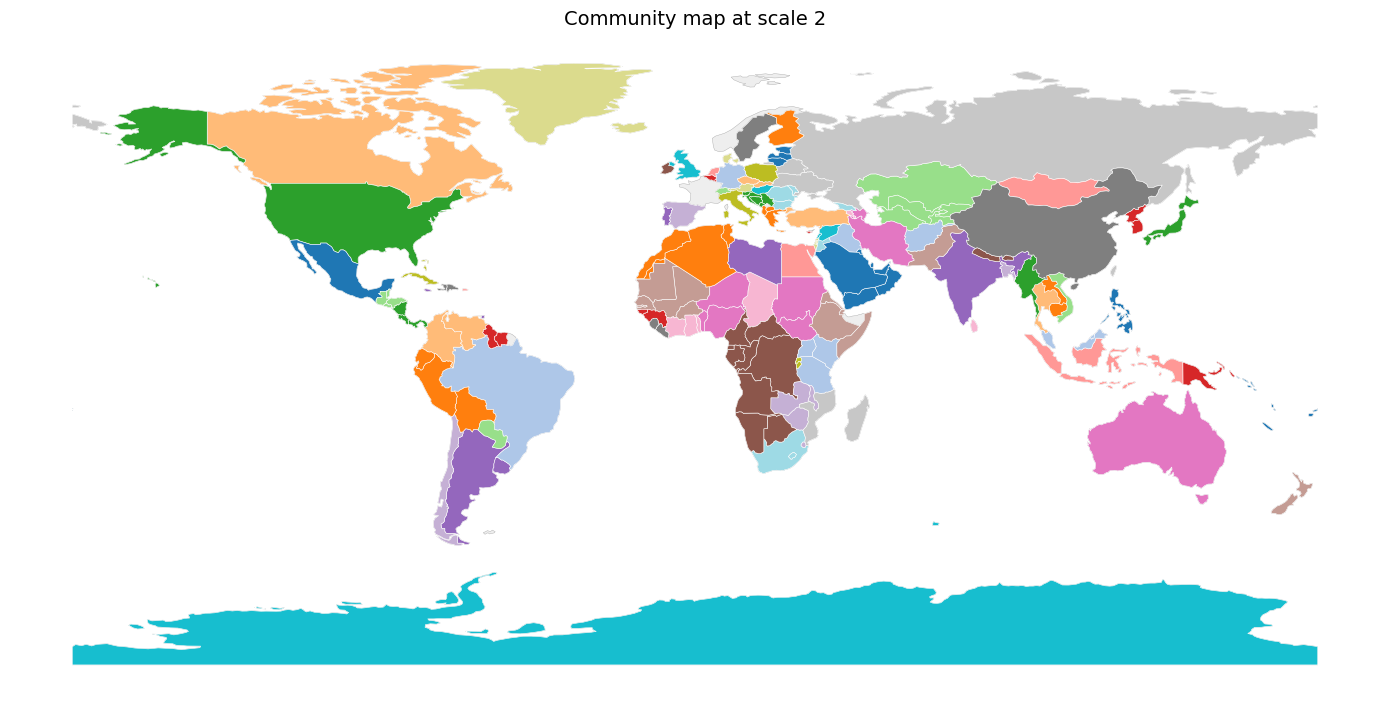


=== Communities at scale 3 ===
Community 0: members=['AUS', 'NZL']
Community 1: members=['USA']
Community 2: members=['DEU']
Community 3: members=['IRL']
Community 4: members=['POL']
Community 5: members=['SWE', 'NOR']
Community 6: members=['CAN', 'SPM']
Community 7: members=['CHL', 'ARG', 'URY']
Community 8: members=['BLR', 'RUS', 'UKR']
Community 9: members=['ITA']
Community 10: members=['GRC', 'ALB', 'MKD', 'XKS']
Community 11: members=['MEX']
Community 12: members=['ISL', 'ATA', 'GRL', 'FRO', 'BVT', 'ATF', 'SGS', 'HMD']
Community 13: members=['CHN']
Community 14: members=['KAZ', 'UZB', 'TJK', 'KGZ', 'TKM']
Community 15: members=['UGA', 'TZA', 'KEN', 'RWA', 'ZMB', 'MWI', 'BDI']
Community 16: members=['GBR', 'IMN', 'SJM']
Community 17: members=['MYS', 'IDN', 'BRN', 'TLS']
Community 18: members=['CZE', 'HUN', 'SVK', 'CSK']
Community 19: members=['FRA']
Community 20: members=['DNK']
Community 21: members=['FIN', 'ALA']
Community 22: members=['ESP', 'PRT', 'AND']
Community 23: members=

/var/folders/fp/k9ggh24n5jv5pqnjc2558lf80000gn/T/ipykernel_83125/4196389305.py:49: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



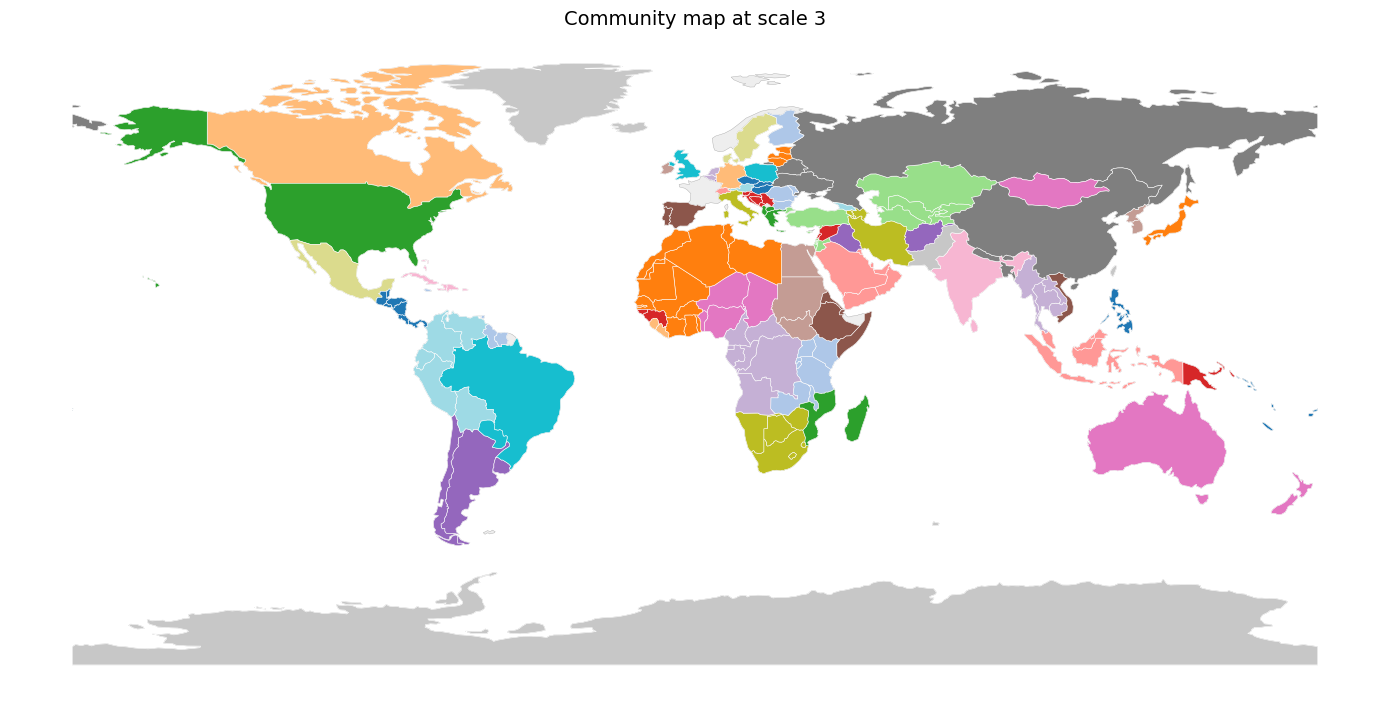


=== Communities at scale 4 ===
Community 0: members=['AUS', 'NZL', 'CXR', 'NFK', 'CCK']
Community 1: members=['USA']
Community 2: members=['DEU']
Community 3: members=['IRL', 'GBR', 'IMN', 'SJM']
Community 4: members=['POL', 'CZE', 'HUN', 'SVK', 'CSK']
Community 5: members=['SWE', 'FIN', 'NOR', 'ALA']
Community 6: members=['CAN', 'SPM']
Community 7: members=['CHL', 'ARG', 'URY']
Community 8: members=['BLR', 'RUS', 'UKR', 'SUN']
Community 9: members=['ITA', 'SMR']
Community 10: members=['GRC', 'ALB', 'MKD', 'XKS']
Community 11: members=['MEX']
Community 12: members=['ISL', 'ATA', 'GRL', 'FRO', 'BVT', 'ATF', 'SGS', 'HMD']
Community 13: members=['CHN', 'MNG']
Community 14: members=['KAZ', 'UZB', 'TJK', 'KGZ', 'TKM']
Community 15: members=['UGA', 'TZA', 'KEN', 'RWA', 'ZMB', 'MWI', 'BDI']
Community 16: members=['MYS', 'IDN', 'SGP', 'BRN', 'TLS']
Community 17: members=['FRA', 'MCO']
Community 18: members=['DNK']
Community 19: members=['ESP', 'PRT', 'GIB', 'AND']
Community 20: members=['ISR'

/var/folders/fp/k9ggh24n5jv5pqnjc2558lf80000gn/T/ipykernel_83125/4196389305.py:49: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



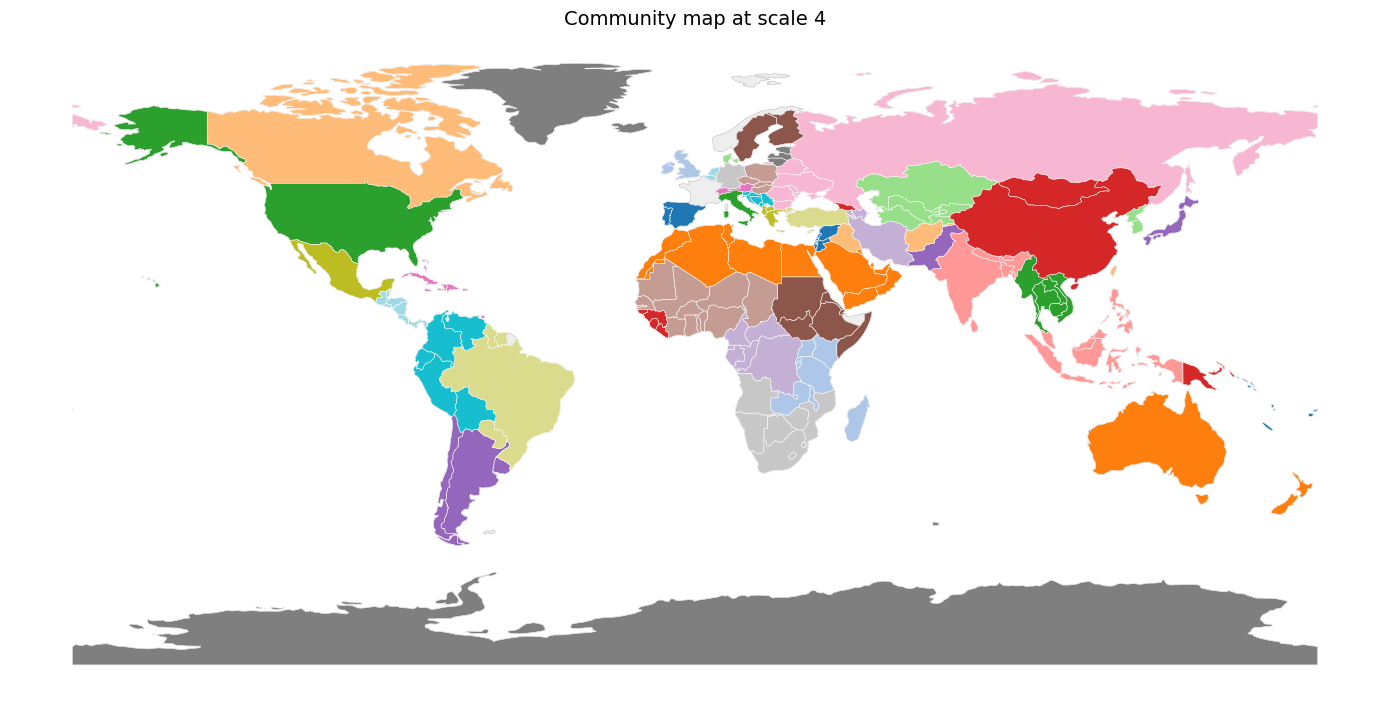


=== Communities at scale 5 ===
Community 0: members=['AUS', 'NZL', 'CXR', 'NFK', 'CCK']
Community 1: members=['USA']
Community 2: members=['DEU']
Community 3: members=['IRL', 'GBR', 'IMN', 'SJM']
Community 4: members=['POL', 'CZE', 'HUN', 'SVK', 'CSK']
Community 5: members=['SWE', 'DNK', 'FIN', 'NOR', 'ALA']
Community 6: members=['CAN', 'SPM']
Community 7: members=['CHL', 'PER', 'COL', 'BOL', 'ECU', 'VEN']
Community 8: members=['BLR', 'RUS', 'UKR', 'KAZ', 'UZB', 'SUN', 'TJK', 'KGZ', 'TKM']
Community 9: members=['ITA', 'VAT', 'SMR']
Community 10: members=['GRC', 'ALB', 'MKD', 'XKS']
Community 11: members=['MEX']
Community 12: members=['ISL', 'ATA', 'GRL', 'FRO', 'BVT', 'ATF', 'SGS', 'HMD']
Community 13: members=['CHN', 'MNG']
Community 14: members=['UGA', 'SDN', 'TZA', 'KEN', 'SOM', 'RWA', 'ETH', 'SSD', 'BDI', 'ERI', 'DJI']
Community 15: members=['MYS', 'IDN', 'SGP', 'BRN', 'TLS']
Community 16: members=['FRA', 'MCO']
Community 17: members=['ESP', 'PRT', 'GIB', 'AND']
Community 18: memb

/var/folders/fp/k9ggh24n5jv5pqnjc2558lf80000gn/T/ipykernel_83125/4196389305.py:49: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



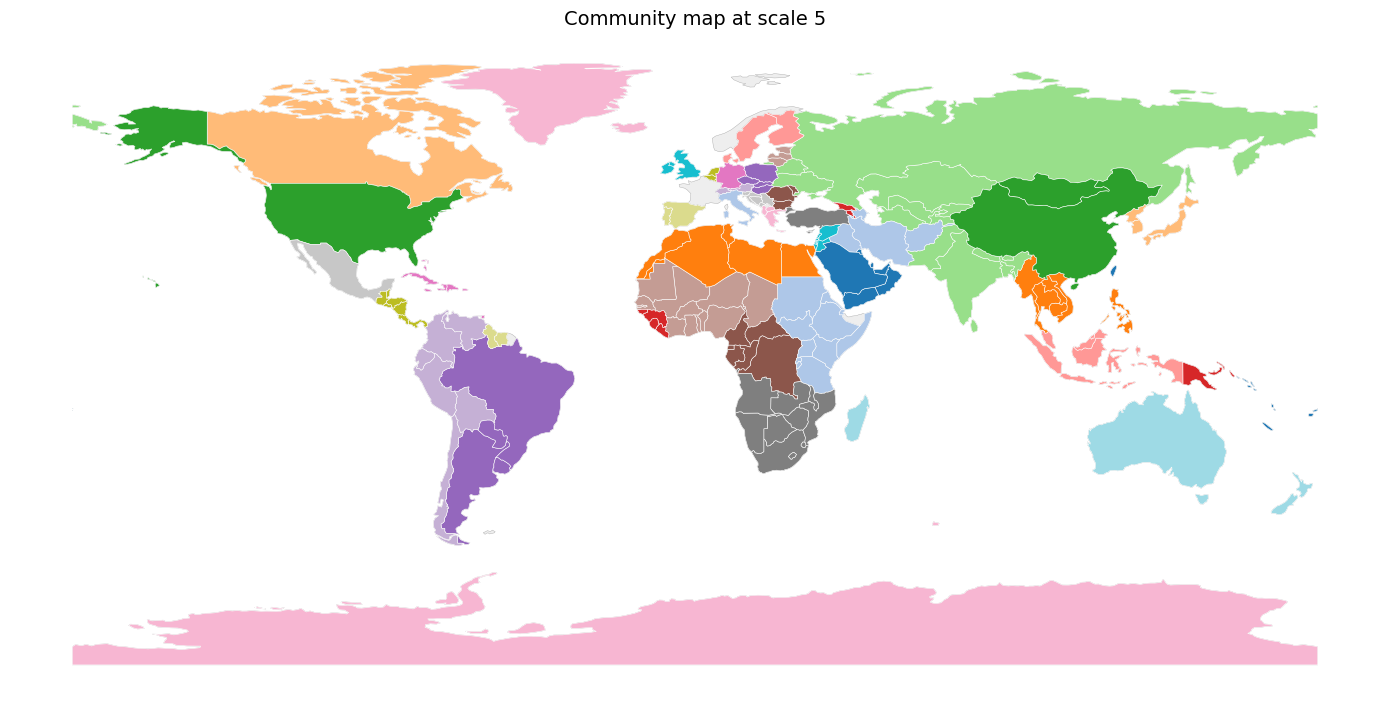


=== Communities at scale 6 ===
Community 0: members=['AUS', 'NZL', 'KIR', 'ATA', 'NCL', 'MNP', 'FJI', 'PYF', 'TON', 'PLW', 'VUT', 'CXR', 'NFK', 'SLB', 'TUV', 'AIA', 'ASM', 'MHL', 'COK', 'WSM', 'GUM', 'NIU', 'TKL', 'PCN', 'BVT', 'NRU', 'ATF', 'WLF', 'CCK', 'SGS', 'HMD']
Community 1: members=['USA', 'CAN', 'MEX', 'GEO', 'PRI', 'JEY', 'SPM']
Community 2: members=['DEU', 'CHE', 'NLD', 'BEL', 'LUX', 'AUT', 'LIE']
Community 3: members=['IRL', 'GBR', 'IMN', 'GGY', 'IOT', 'SJM']
Community 4: members=['POL', 'GRC', 'CZE', 'HUN', 'ROU', 'SRB', 'MDA', 'SVK', 'ALB', 'BGR', 'SVN', 'HRV', 'YUG', 'MKD', 'BIH', 'MNE', 'CSK', 'SCG', 'XKS']
Community 5: members=['SWE', 'ISL', 'DNK', 'FIN', 'NOR', 'EST', 'LTU', 'ALA', 'GRL', 'LVA', 'FRO']
Community 6: members=['CHL', 'ARG', 'BRA', 'PER', 'URY', 'GTM', 'COL', 'BLZ', 'PAN', 'BOL', 'PRY', 'ECU', 'GUY', 'VEN', 'CRI', 'SLV', 'HND', 'GUF', 'SUR', 'NIC']
Community 7: members=['BLR', 'RUS', 'UKR', 'KAZ', 'UZB', 'SUN', 'TJK', 'KGZ', 'TKM']
Community 8: members=[

/var/folders/fp/k9ggh24n5jv5pqnjc2558lf80000gn/T/ipykernel_83125/4196389305.py:49: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



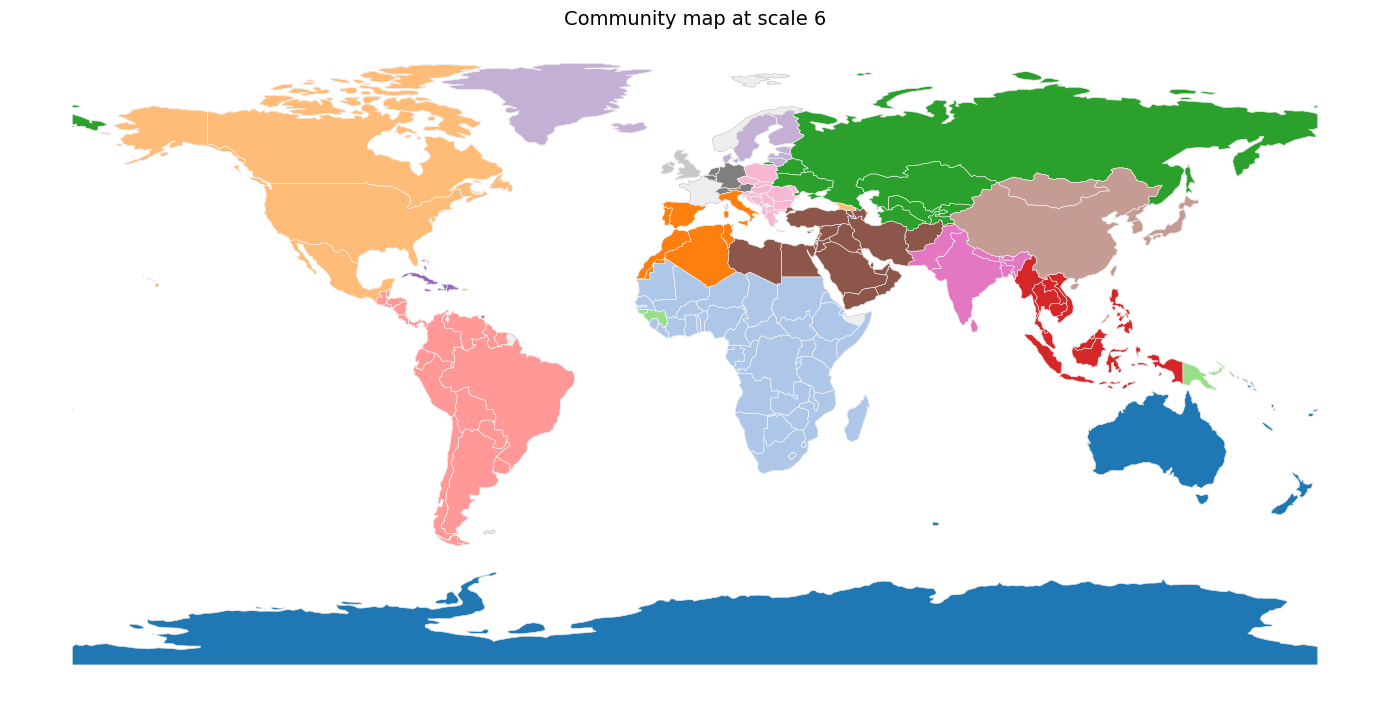


=== Communities at scale 7 ===
Community 0: members=['AUS', 'NZL', 'KIR', 'ATA', 'NCL', 'FJI', 'PYF', 'TON', 'PLW', 'VUT', 'CXR', 'NFK', 'SLB', 'TUV', 'AIA', 'ASM', 'MHL', 'COK', 'WSM', 'NIU', 'TKL', 'PCN', 'BVT', 'NRU', 'ATF', 'WLF', 'CCK', 'SGS', 'HMD']
Community 1: members=['USA', 'CAN', 'MEX', 'GEO', 'PRI', 'MNP', 'JEY', 'GUM', 'BMU', 'SPM']
Community 2: members=['DEU', 'ITA', 'FRA', 'ESP', 'CHE', 'NLD', 'PRT', 'BEL', 'LUX', 'AUT', 'GIB', 'LIE', 'VAT', 'AND', 'SMR', 'MCO']
Community 3: members=['IRL', 'GBR', 'IMN', 'GGY', 'IOT', 'SJM']
Community 4: members=['POL', 'BLR', 'RUS', 'UKR', 'KAZ', 'UZB', 'CZE', 'HUN', 'ROU', 'SRB', 'EST', 'SUN', 'MDA', 'SVK', 'LTU', 'TJK', 'BGR', 'SVN', 'LVA', 'HRV', 'KGZ', 'YUG', 'BIH', 'TKM', 'MNE', 'CSK', 'SCG']
Community 5: members=['SWE', 'ISL', 'DNK', 'FIN', 'NOR', 'ALA', 'GRL', 'FRO']
Community 6: members=['CHL', 'ARG', 'BRA', 'PER', 'URY', 'GTM', 'COL', 'BLZ', 'PAN', 'CUB', 'BOL', 'PRY', 'ECU', 'GUY', 'ANT', 'CUW', 'VEN', 'CRI', 'SLV', 'DMA', 'M

/var/folders/fp/k9ggh24n5jv5pqnjc2558lf80000gn/T/ipykernel_83125/4196389305.py:49: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



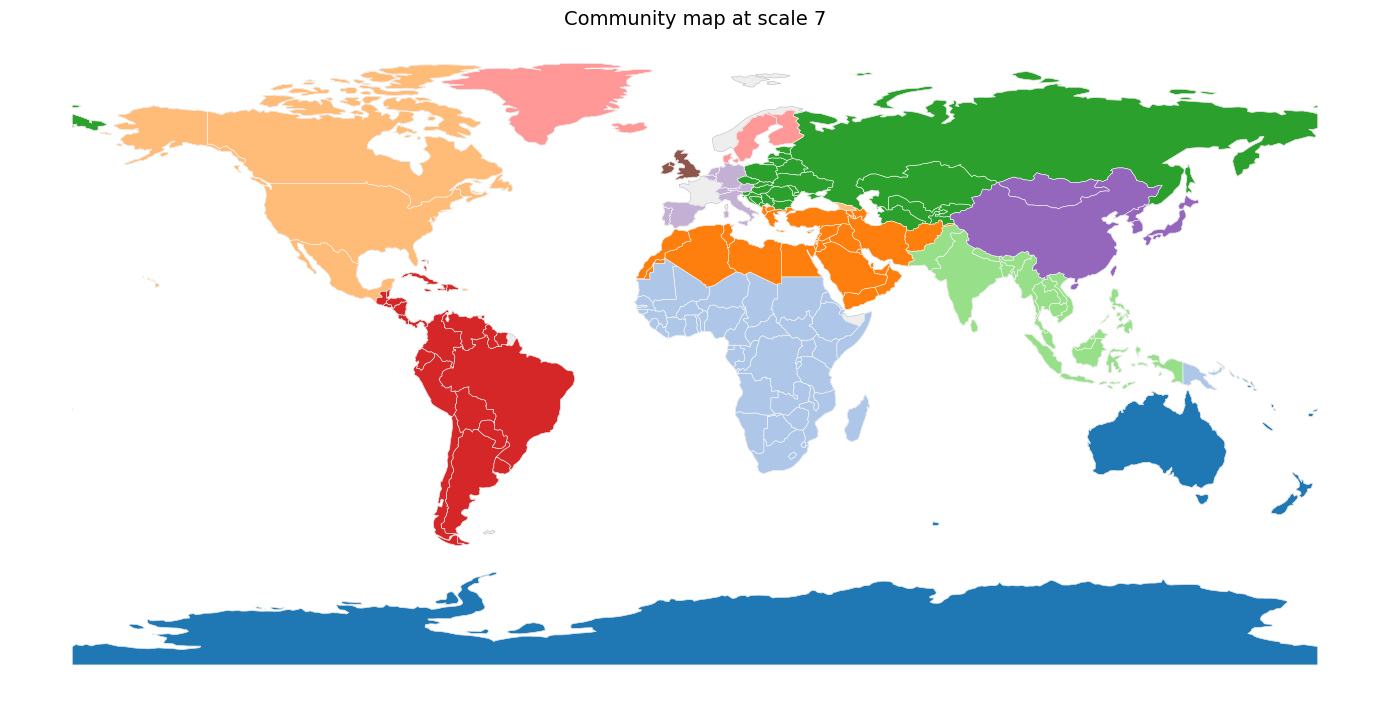


=== Communities at scale 8 ===
Community 0: members=['AUS', 'NZL', 'KIR', 'ATA', 'NCL', 'FJI', 'PYF', 'TON', 'PLW', 'VUT', 'CXR', 'NFK', 'SLB', 'TUV', 'AIA', 'ASM', 'TLS', 'MHL', 'COK', 'WSM', 'NIU', 'TKL', 'PCN', 'BVT', 'NRU', 'ATF', 'WLF', 'CCK', 'SGS', 'HMD']
Community 1: members=['USA', 'CAN', 'MEX', 'GEO', 'PRI', 'MNP', 'JEY', 'GUM', 'BMU', 'GGY', 'SPM']
Community 2: members=['DEU', 'IRL', 'ITA', 'GBR', 'FRA', 'ESP', 'CHE', 'NLD', 'PRT', 'BEL', 'LUX', 'AUT', 'GIB', 'IMN', 'MLT', 'LIE', 'VAT', 'AND', 'SMR', 'MCO', 'SJM']
Community 3: members=['POL', 'BLR', 'RUS', 'UKR', 'KAZ', 'UZB', 'CZE', 'HUN', 'ROU', 'SRB', 'EST', 'SUN', 'MDA', 'SVK', 'LTU', 'TJK', 'BGR', 'SVN', 'LVA', 'HRV', 'KGZ', 'YUG', 'BIH', 'TKM', 'MNE', 'CSK', 'SCG']
Community 4: members=['SWE', 'ISL', 'DNK', 'FIN', 'NOR', 'ALA', 'GRL', 'FRO']
Community 5: members=['CHL', 'ARG', 'BRA', 'PER', 'URY', 'GTM', 'COL', 'BLZ', 'PAN', 'CUB', 'BOL', 'PRY', 'ECU', 'GUY', 'ANT', 'CUW', 'VEN', 'CRI', 'SLV', 'DMA', 'MSR', 'MTQ', 'BH

/var/folders/fp/k9ggh24n5jv5pqnjc2558lf80000gn/T/ipykernel_83125/4196389305.py:49: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



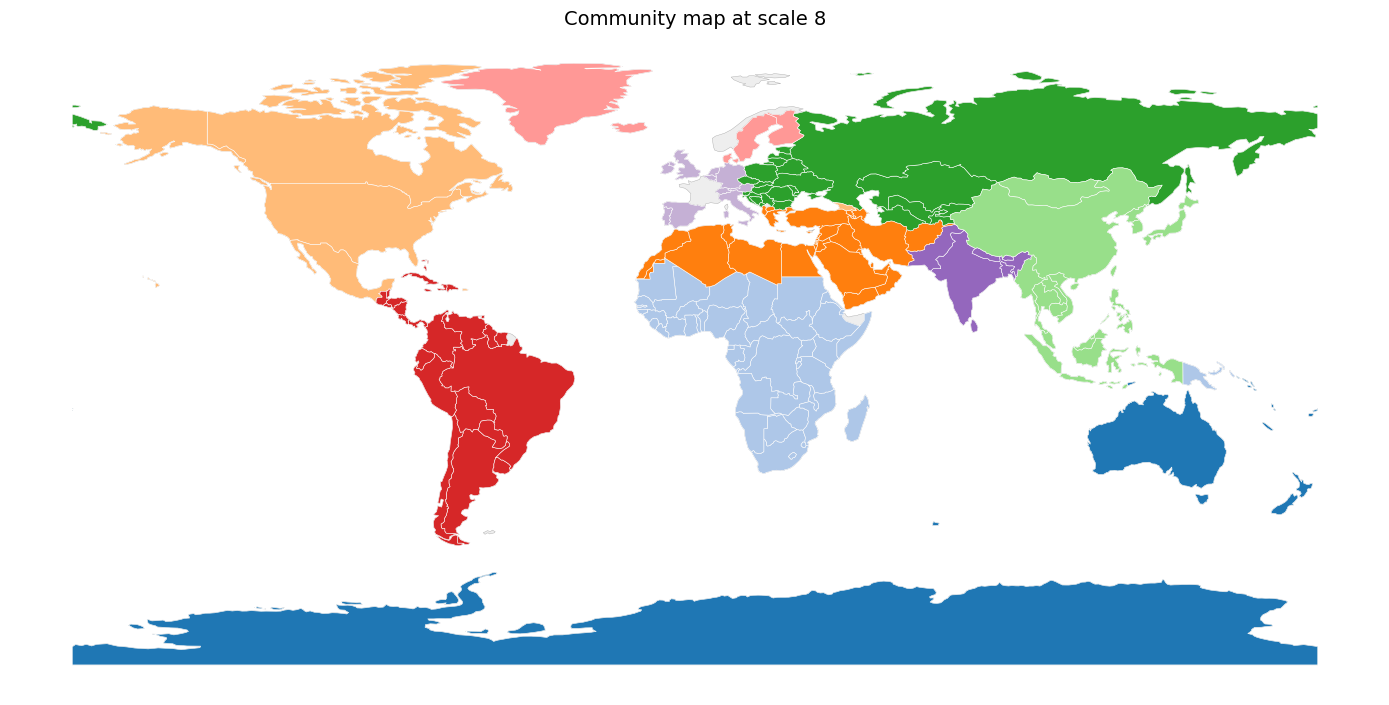

In [9]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


selected_scales = results["selected_partitions"]

# --- Load Natural Earth countries from NACIS CDN (works on GeoPandas 1.x) ---
def prep_world_gdf():
    url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
    gdf = gpd.read_file(url)

    # Robustly find ISO3 column
    cand_cols = ["ISO_A3", "ADM0_A3", "iso_a3", "adm0_a3"]
    iso_col = next((c for c in cand_cols if c in gdf.columns), None)
    if iso_col is None:
        raise KeyError(f"Could not find ISO3 column in columns: {gdf.columns.tolist()}")

    gdf["ISO3"] = gdf[iso_col].replace({"-99": None})
    return gdf

def plot_communities_on_map(node_order, labels, world_gdf, title="", ax=None):
    # Build mapping DF
    lab = pd.Series(labels, index=node_order, name="community")
    df = lab.reset_index().rename(columns={"index": "ISO3"})

    # Optional code fixes (your graph codes -> NE ISO3)
    code_fix = {"ROM": "ROU", "UK": "GBR", "EL": "GRC"}
    df["ISO3"] = df["ISO3"].replace(code_fix)

    gdf = world_gdf.merge(df, on="ISO3", how="left")

    # Factorize to contiguous codes for discrete colormap
    present = gdf["community"].dropna()
    if len(present) == 0:
        if ax is None:
            _, ax = plt.subplots(figsize=(14, 8))
        gdf.plot(ax=ax, color="#EEEEEE", edgecolor="#AAAAAA", linewidth=0.3)
        ax.set_title(title); ax.set_axis_off(); plt.tight_layout(); plt.show()
        return

    codes, uniques = pd.factorize(present.astype(int))  # uniques = original community IDs
    gdf.loc[present.index, "comm_code"] = codes

    k = len(uniques)
    cmap = ListedColormap([cm.get_cmap("tab20")(i % 20) for i in range(k)])

    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 8))

    # Base layer
    gdf.plot(ax=ax, color="#EEEEEE", edgecolor="#AAAAAA", linewidth=0.3)

    # Communities layer
    gdf.dropna(subset=["comm_code"]).plot(
        ax=ax,
        column="comm_code",
        cmap=cmap,
        linewidth=0.4,
        edgecolor="white",
        legend=False,
    )

    # Legend with original IDs
    patches = [mpatches.Patch(color=cmap(i), label=f"C{int(cid)}") for i, cid in enumerate(uniques)]
    #ax.legend(handles=patches, title="Communities", loc="lower left", frameon=True)

    ax.set_title(title, fontsize=14)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()


# === Usage ===
world_gdf = prep_world_gdf()

for idx, part_idx in enumerate(selected_scales):
    labels = results["community_id"][part_idx]  # aligned with node_order

    # Optional: print members
    comms = dict(zip(node_order, labels))
    community_map = {}
    for node, cid in comms.items():
        community_map.setdefault(int(cid), []).append(node)

    print(f"\n=== Communities at scale {idx+1} ===")
    for cid in sorted(community_map):
        print(f"Community {cid}: members={community_map[cid]}")

    plot_communities_on_map(
        node_order=node_order,
        labels=labels,
        world_gdf=world_gdf,
        title=f"Community map at scale {idx+1}",
    )
